# Advanced Machine Learning
## Project 1 - Optimization Algorithms
### Authors: Bartosz Grabek, Izabela Telejko, Grzegorz Zbrzeżny

In [1]:
import numpy as np
from utils.train_functions import cv
from utils.preprocess_functions import(
    preprocess_booking, # SGD might not be converging
    preprocess_churn, # OK
    preprocess_employee, # SGD might not be converging
    preprocess_challenger, # SUS
    preprocess_jungle,
    preprocess_water # OK
)
from optim import GD, ADAM, IWLS
from utils.plots import (
    plot_figures_for_cv,
    plot_acc_boxplots
)

### TODO:
Some columns in X_challenger and X_jungle have only 0 values

In [5]:
sgd_acc_list, adam_acc_list, iwls_acc_list, l_iwls_vals_list, l_sgd_vals_list, l_adam_vals_list = cv(preprocess_churn, n_splits=2)

CV split 1
Removing multicolinear columns in churn dataset...


ADAM:  33%|███▎      | 166/500 [00:03<00:07, 45.55it/s]


Balanced accuracy of SGD without optimizer is: 0.5464539007092198
Balanced accuracy of GD with ADAM is: 0.6632624113475177
Balanced accuracy of IWLS is: 0.6590780141843972
Balanced accuracy of LR from Scikit is 0.6526241134751773
CV split 2
Removing multicolinear columns in churn dataset...


ADAM:  48%|████▊     | 239/500 [00:05<00:05, 44.88it/s]

Balanced accuracy of SGD without optimizer is: 0.5808943089430895
Balanced accuracy of GD with ADAM is: 0.7071544715447156
Balanced accuracy of IWLS is: 0.719349593495935
Balanced accuracy of LR from Scikit is 0.719349593495935


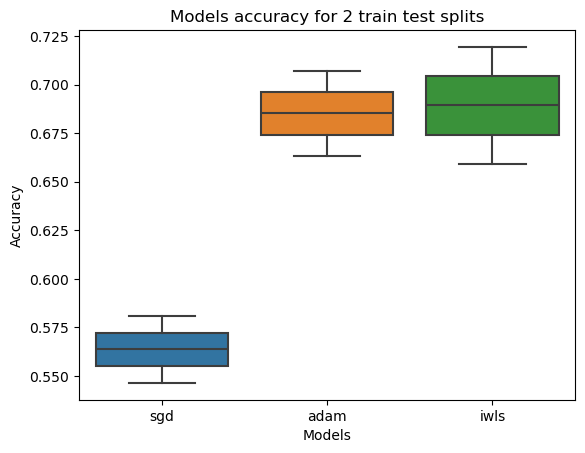

In [6]:
plot_acc_boxplots(sgd_acc_list, adam_acc_list, iwls_acc_list)

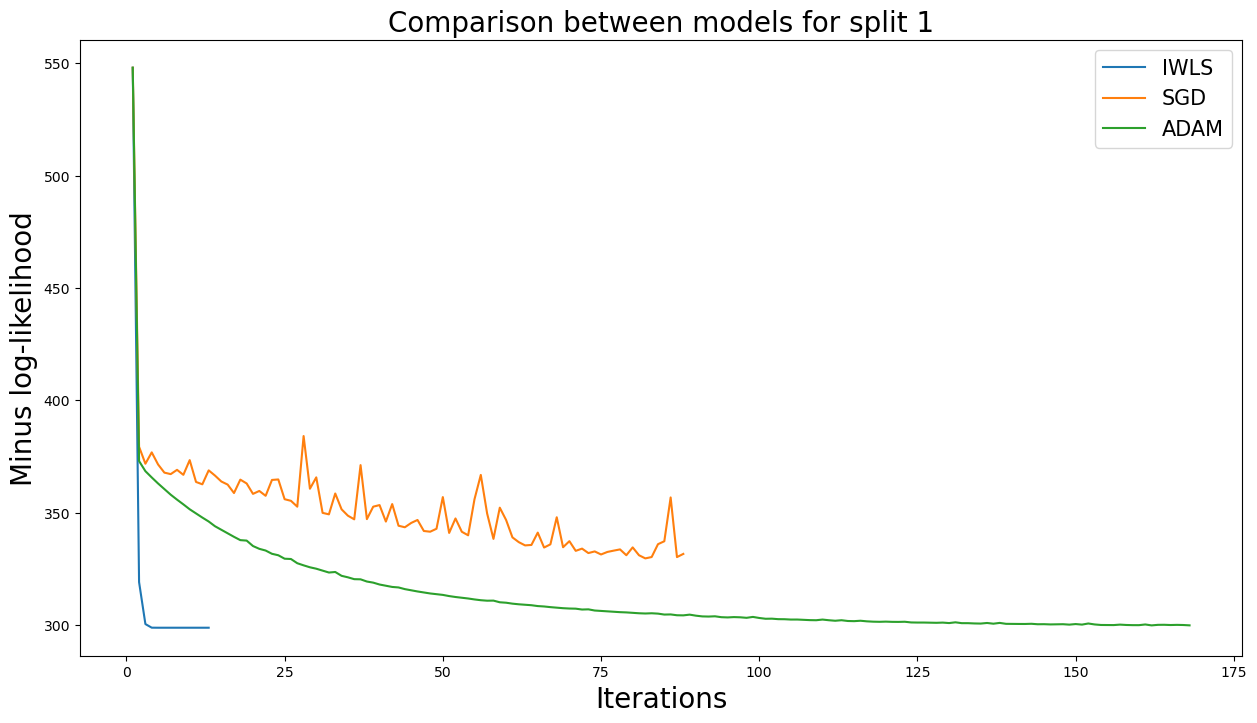

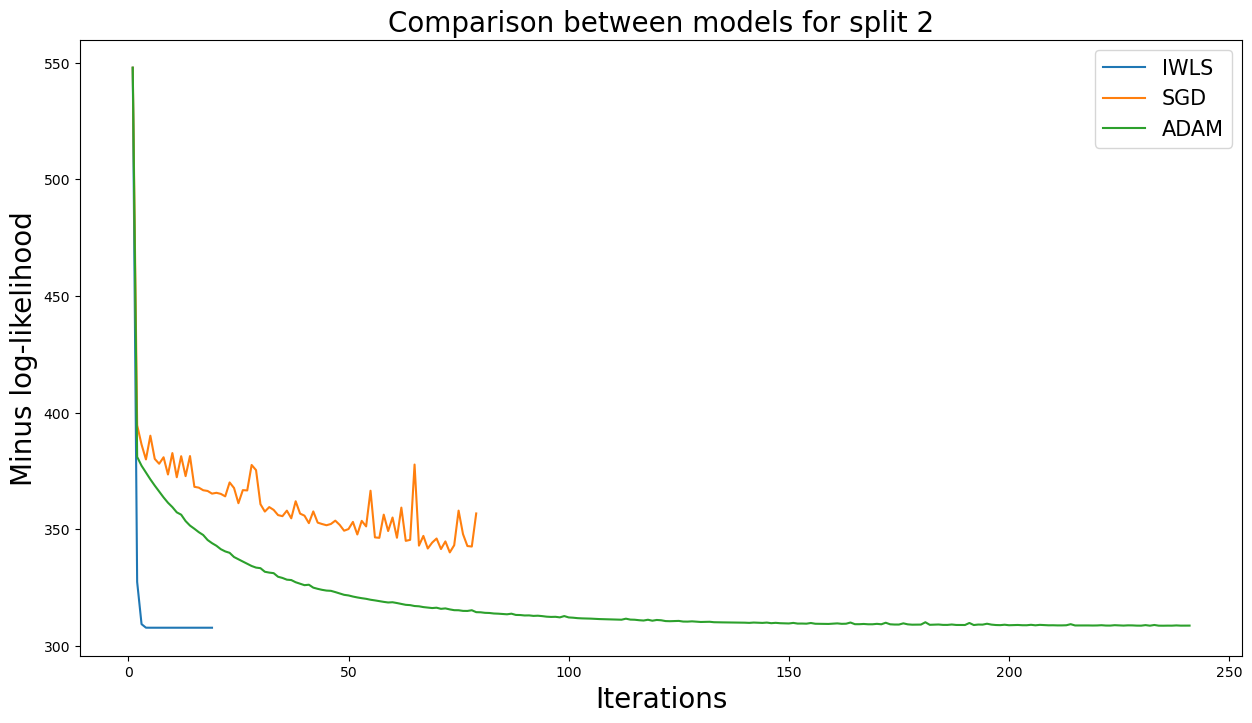

In [7]:
plot_figures_for_cv(l_iwls_vals_list, l_sgd_vals_list, l_adam_vals_list)

### Data generated from logistic model

In [8]:
beta1 = 2

n1 = 1000
x1 = np.random.exponential(1, size=n1)

n2 = 1000
x2 = np.random.exponential(1/(beta1+1), size=n2)

X = np.expand_dims(np.concatenate((x1, x2), axis=0), axis=1)
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
y = np.expand_dims(np.concatenate((np.ones((1, n1)), np.zeros((1, n2))), axis=1)[0], 1)

In [9]:
pi = n1 / (n1 + n2)
b0 = -np.log((1 + beta1) * ((1-pi)/pi))

In [10]:
iwls = IWLS(n_iter=100)
gd = GD(learning_rate=0.0002, n_epoch=200)
adam = ADAM(learning_rate=0.0002, n_epoch=200)

l_iwls_vals, best_beta_iwls = iwls.optimize(X, y)
l_sgd_vals, best_beta_sgd = gd.optimize(X, y)
l_adam_vals, best_beta_adam = adam.optimize(X, y)

ADAM:  79%|███████▉  | 158/200 [00:08<00:02, 18.31it/s]


In [11]:
print(f"Theoretical betas: b0: {b0}, b1: {beta1}" )
print(f"Empirical betas for SGD without optimizers: b0: {best_beta_sgd[0]}, b1: {best_beta_sgd[1]}")
print(f"Empirical betas for SGD with ADAM: b0: {best_beta_adam[0]}, b1: {best_beta_adam[1]}")
print(f"Empirical betas for IWLS: b0: {best_beta_iwls[0][0]}, b1: {best_beta_iwls[1][0]}")

Theoretical betas: b0: -1.0986122886681096, b1: 2
Empirical betas for SGD without optimizers: b0: -1.0707366327279129, b1: 1.942138609500362
Empirical betas for SGD with ADAM: b0: -1.1649223775488144, b1: 2.1184070909189283
Empirical betas for IWLS: b0: -1.1662671816756378, b1: 2.1220842464321956
